In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import numpy as np
from experiment_analyser import ExperimentAnalyzer

# Configurações para melhor visualização
%matplotlib inline
sns.set(style="whitegrid")

In [3]:
# Definição do diretório base onde estão armazenados os resultados dos experimentos
base_dir = '/data/joao/mtsa/experiment_final2'

# Instancia o analisador
exp_analyzer = ExperimentAnalyzer(base_dir=base_dir)

# Executa a análise completa
exp_analyzer.run_analysis(group_by_params=['max_samples', 'n_estimators'])

# Define a pasta onde estão as estatísticas de intervalos de confiança
confidence_intervals_base = os.path.join(base_dir, 'confidence_interval_*')

# Obtém a lista de pastas de intervalos de confiança usando glob
confidence_folders = glob.glob(os.path.join(base_dir, 'confidence_interval_*'))

# Definição das cores para max_samples
color_map = {
    128: 'blue',
    512: 'green'
}

# Cria uma pasta para salvar os gráficos com intervalos de confiança, se não existir
conf_int_dir = os.path.join(base_dir, 'confidence_intervals_plots2')
os.makedirs(conf_int_dir, exist_ok=True)

Ignorando a subpasta desconhecida: confidence_interval_FAN_00
Ignorando a subpasta desconhecida: confidence_interval_SLIDER_00
Ignorando a subpasta desconhecida: heatmaps2
Ignorando a subpasta desconhecida: confidence_interval_VALVE_00
Ignorando a subpasta desconhecida: confidence_interval_PUMP_00
Estatísticas salvas em: /data/joao/mtsa/experiment_final2/confidence_interval_FAN_00/statistics_max_samples-128_n_estimators-2.csv
Estatísticas salvas em: /data/joao/mtsa/experiment_final2/confidence_interval_FAN_00/statistics_max_samples-128_n_estimators-10.csv
Estatísticas salvas em: /data/joao/mtsa/experiment_final2/confidence_interval_FAN_00/statistics_max_samples-128_n_estimators-40.csv
Estatísticas salvas em: /data/joao/mtsa/experiment_final2/confidence_interval_FAN_00/statistics_max_samples-128_n_estimators-70.csv
Estatísticas salvas em: /data/joao/mtsa/experiment_final2/confidence_interval_FAN_00/statistics_max_samples-128_n_estimators-100.csv
Estatísticas salvas em: /data/joao/mtsa/e

Gráfico com intervalos de confiança salvo em: /data/joao/mtsa/experiment_final2/confidence_intervals_plots2/conf_int_FAN_00.png


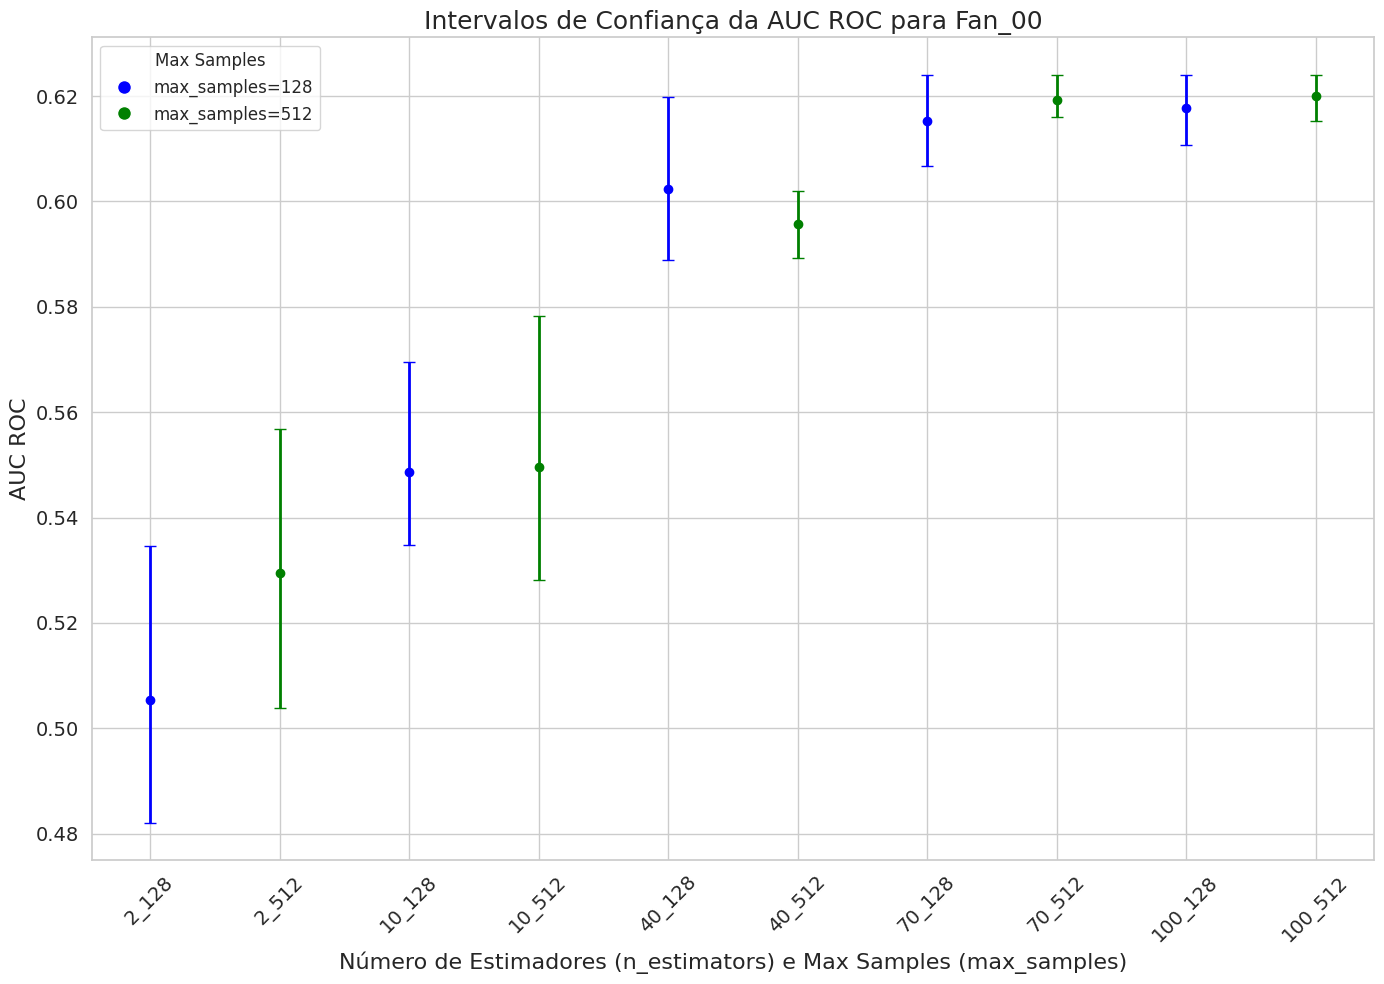

Gráfico com intervalos de confiança salvo em: /data/joao/mtsa/experiment_final2/confidence_intervals_plots2/conf_int_SLIDER_00.png


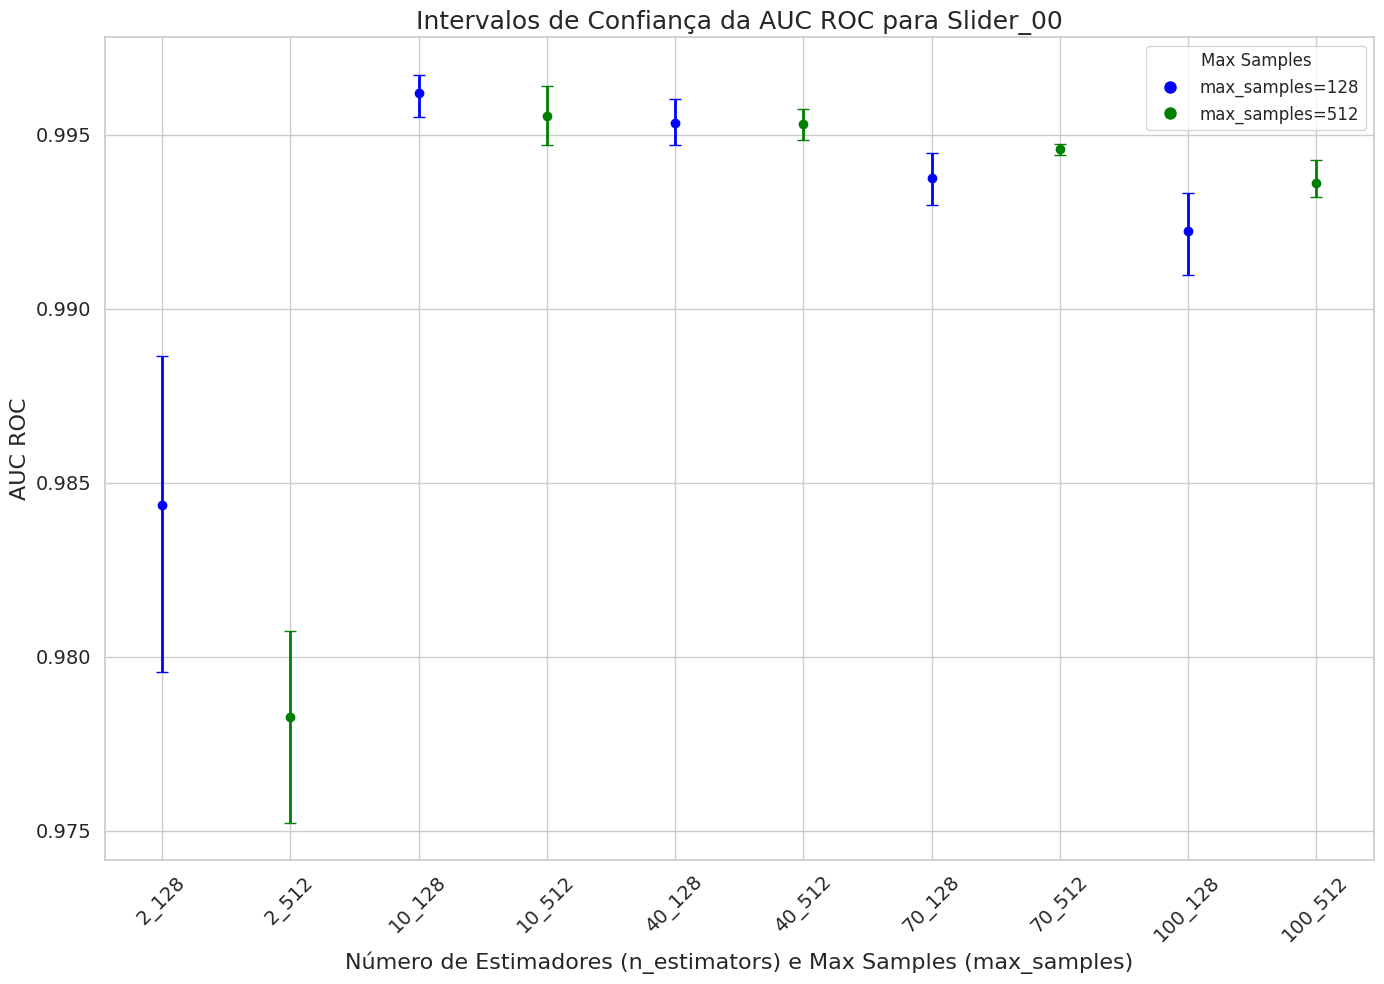

Gráfico com intervalos de confiança salvo em: /data/joao/mtsa/experiment_final2/confidence_intervals_plots2/conf_int_VALVE_00.png


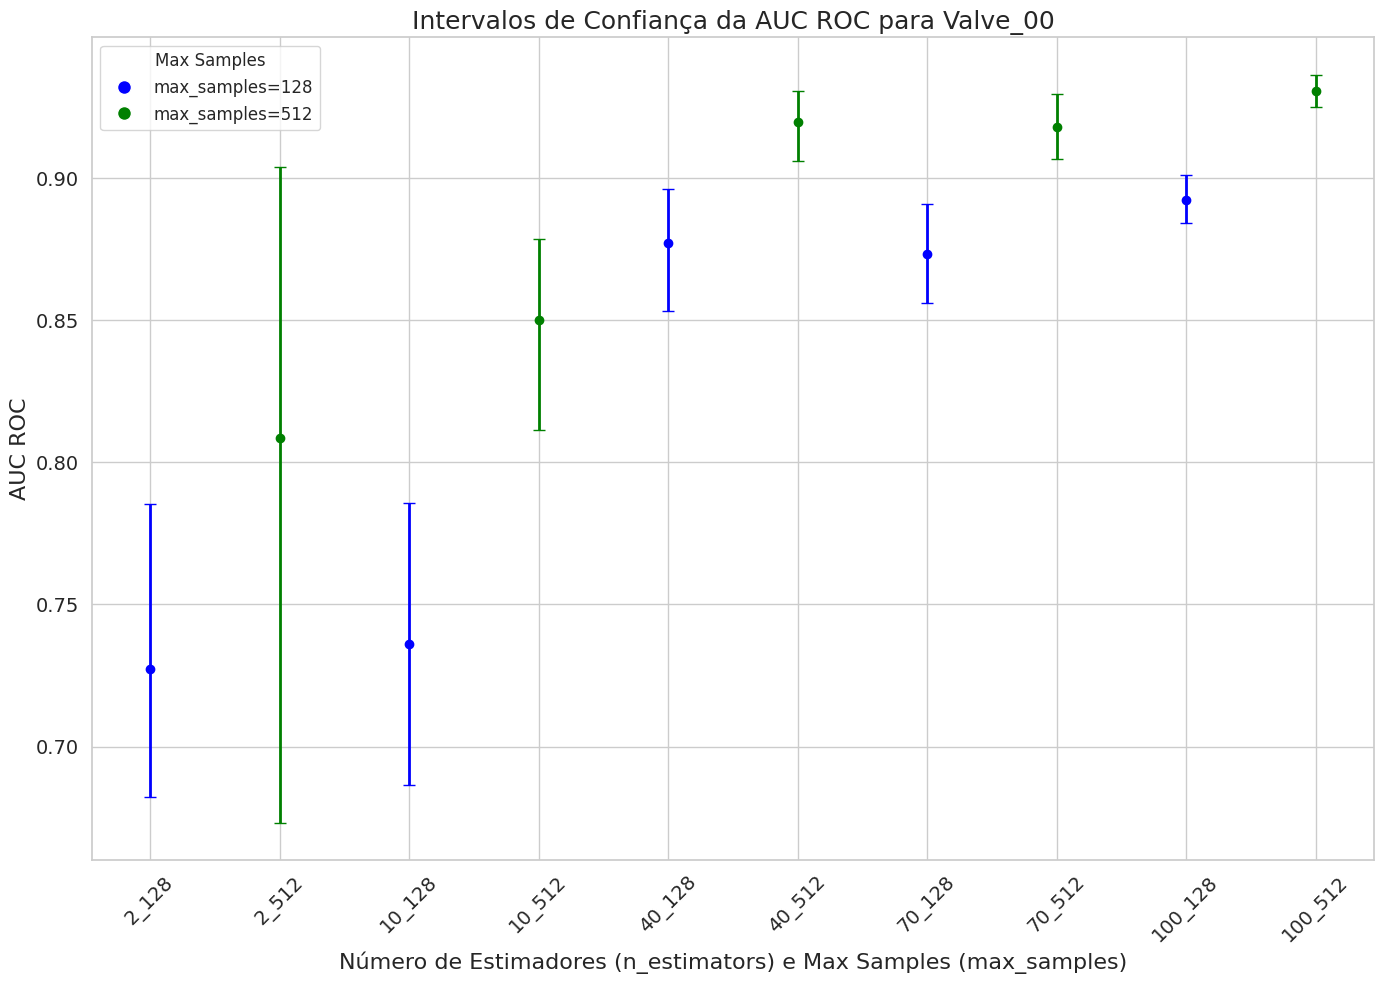

Gráfico com intervalos de confiança salvo em: /data/joao/mtsa/experiment_final2/confidence_intervals_plots2/conf_int_PUMP_00.png


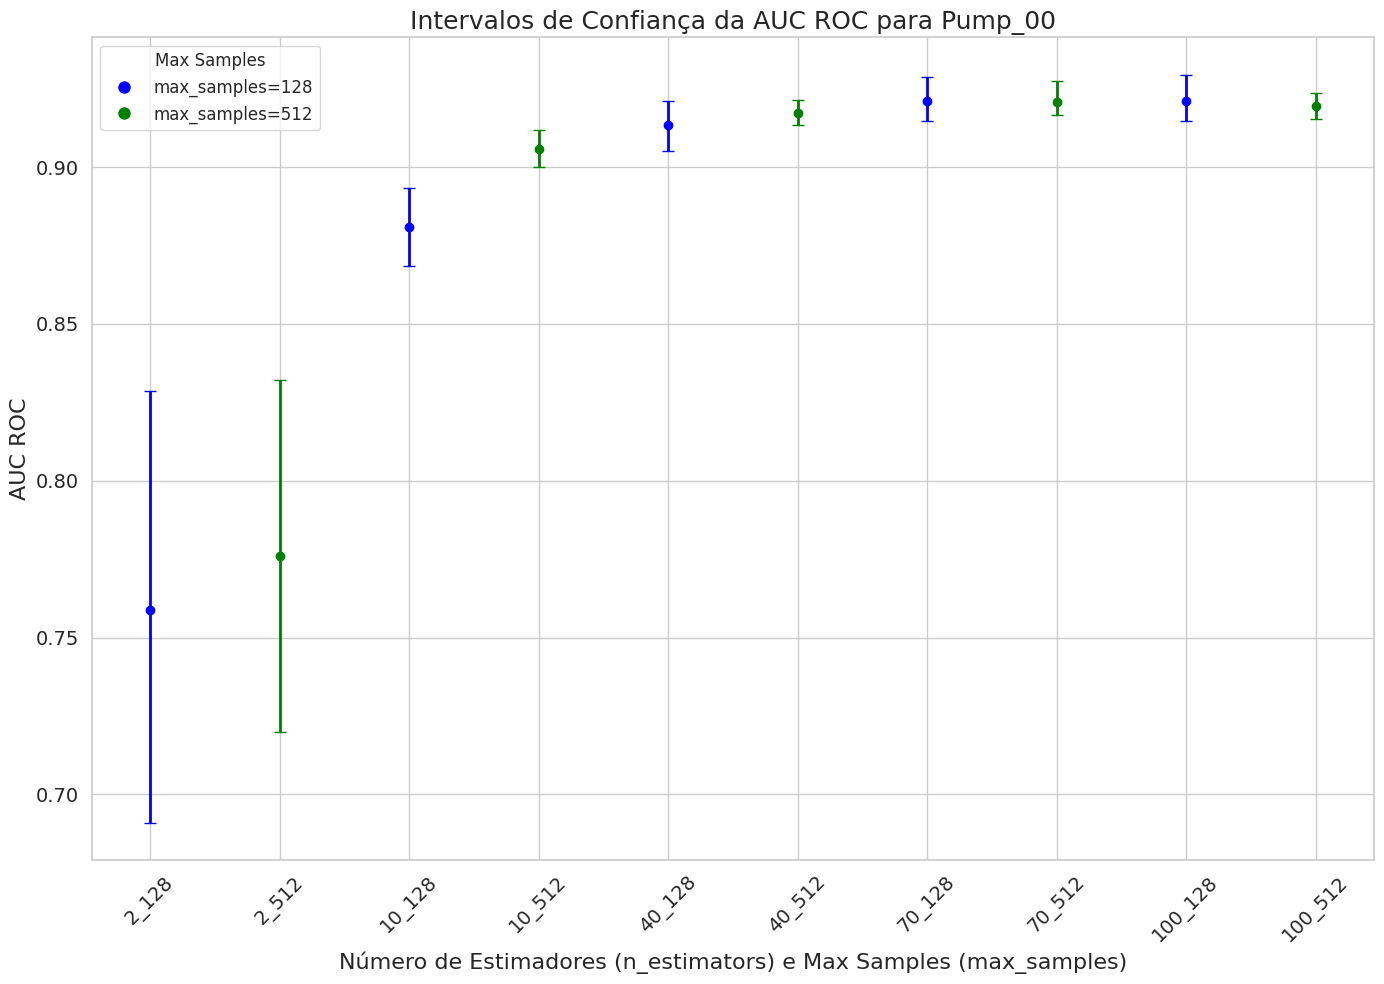

In [ ]:
# Definir limites e intervalos do eixo Y
y_min = 0.4
y_max = 1.0
y_ticks = [round(i, 2) for i in np.arange(y_min, y_max + 0.1, 0.1)]

# Loop sobre cada pasta de intervalos de confiança
for folder in confidence_folders:
    folder_name = os.path.basename(folder)
    
    # Extrai o machine_type e machine_id da pasta
    # Supondo que o nome da pasta siga o padrão 'confidence_interval_{machine_type}_{machine_id}'
    parts = folder_name.split('_')
    if len(parts) < 4:
        print(f"Formato de pasta desconhecido: {folder_name}. Ignorando.")
        continue
    machine_type = parts[2]
    machine_id = parts[3]
    
    # Lista todos os arquivos CSV na pasta
    csv_files = [file for file in os.listdir(folder) if file.endswith('.csv')]
    
    if not csv_files:
        print(f"Nenhum arquivo CSV encontrado na pasta: {folder_name}")
        continue
    
    # Carrega todos os arquivos CSV em um DataFrame
    df_list = []
    for file in csv_files:
        file_path = os.path.join(folder, file)
        try:
            df = pd.read_csv(file_path)
            df_list.append(df)
        except Exception as e:
            print(f"Erro ao ler o arquivo {file_path}: {e}")
            continue
    
    if not df_list:
        print(f"Nenhum dado carregado na pasta: {folder_name}")
        continue
    
    # Concatena todos os DataFrames
    df_stats = pd.concat(df_list, ignore_index=True)
    
    # Verifica se o DataFrame contém as colunas necessárias
    required_columns = ['max_samples', 'n_estimators', 'Mean_AUC_ROC', 'CI_lower', 'CI_upper']
    if not all(col in df_stats.columns for col in required_columns):
        print(f"Colunas faltando no DataFrame da pasta {folder_name}. Ignorando.")
        continue
    
    # Cria uma coluna para duplicar os valores de n_estimators para cada max_samples
    # Isso resultará em x=2,2,10,10,... onde cada par corresponde a um max_samples diferente
    df_stats['n_estimators_dup'] = df_stats['n_estimators'].astype(str) + "_" + df_stats['max_samples'].astype(str)
    
    # Ordena o DataFrame para garantir que os valores estejam na ordem correta
    df_stats = df_stats.sort_values(['n_estimators', 'max_samples'])
    
    # Inicia a plotagem
    plt.figure(figsize=(14, 10))
    
    # Plot das médias com intervalos de confiança
    for _, row in df_stats.iterrows():
        x = row['n_estimators_dup']
        y = row['Mean_AUC_ROC']
        yerr = [[y - row['CI_lower']], [row['CI_upper'] - y]]
        color = color_map.get(row['max_samples'], 'gray')
        plt.errorbar(
            x,
            y,
            yerr=yerr,
            fmt='o',
            color=color,
            ecolor=color,
            elinewidth=2,
            capsize=4
        )
    
    # Configurações dos eixos
    plt.xlabel('Número de Estimadores (n_estimators) e Max Samples (max_samples)', fontsize=18)
    plt.ylabel('AUC ROC', fontsize=18)
    plt.title(f'Intervalos de Confiança da AUC ROC para {machine_type.capitalize()}_{machine_id}', fontsize=20)
    plt.xticks(fontsize=16, rotation=45)
    plt.yticks(fontsize=16)
    
    # Cria uma legenda personalizada
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'max_samples={mf}',
                          markerfacecolor=color_map[mf], markersize=10) for mf in color_map]
    plt.legend(handles=handles, title='Max Samples', fontsize=12)
    
    # Ajusta o layout para melhor visualização
    plt.tight_layout()
    
    # Define o caminho para salvar o gráfico
    plot_filename = f'conf_int_{machine_type}_{machine_id}.png'
    plot_path = os.path.join(conf_int_dir, plot_filename)
    plt.savefig(plot_path, bbox_inches='tight')
    print(f'Gráfico com intervalos de confiança salvo em: {plot_path}')
    
    # Exibe o gráfico
    plt.show()